# Comparison of different solutions

This notebook is intended to compare different toolboxes for solving an island network model. 
![The structure of the model](images/MG_2_node_Singleline.jpg)

The ODEs result from the problem shown here. The exact derivation of the equations can be found in the PDF-file.

## GEKKO

GEKKO is optimization software for mixed-integer and differential algebraic equations. It is coupled with large-scale solvers for linear, quadratic, nonlinear, and mixed integer programming (LP, QP, NLP, MILP, MINLP). Modes of operation include data reconciliation, real-time optimization, dynamic simulation, and nonlinear predictive control. (Source:https://gekko.readthedocs.io/en/latest/overview.html)

In [1]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define time vector
ts = 1e-4
t_end = 0.005
steps = int(1/ts)
num_samples = int(steps*t_end) # Number of samples in given time
t = np.linspace(0, t_end, num_samples)

# define values of the parameter
R = 0.4
L = 2.3e-3
C = 10e-6
LT = 2.3e-3
R_load = 14
vi1 = 230
vi2 = 230

In [ ]:
#   Initialize Model empty model as m
m = GEKKO(remote=False)

#Input
vi1 = m.Param(value=vi1)
vi2 = m.Param(value=vi2)

# Mdoel params
R1 = m.Param(value=R)
L1 = m.Param(value=L)
C1 = m.Param(value=C)
RT1 = m.Param(value=R)
LT1 = m.Param(value=LT)

R2 = m.Param(value=R)
L2 = m.Param(value=L)
C2 = m.Param(value=C)
RT2 = m.Param(value=R)
LT2 = m.Param(value=LT)

RLoad = m.Param(value=R_load)
# iLoad = m.Var(value=0) # Commend if you want to "New version"

v1 = m.Var(value=0)
i1 = m.Var(value=0)
v2 = m.Var(value=0)
i2 = m.Var(value=0)
iT1 = m.Var(value=0)
iT2 = m.Var(value=0)

In [ ]:
# define equations

# DGLs node1
m.Equation(i1.dt() == (vi1 - v1)/L1 - R1/L1 * i1)
m.Equation(v1.dt() == (i1 - iT1)/C1)
m.Equation(iT1.dt() == v1 / LT1 - (RT1 + RLoad) / LT1 * iT1 - RLoad / LT1 * iT2)

# DGLs node2
m.Equation(i2.dt() == (vi2 - v2)/L2 - R2/L2 * i2)
m.Equation(v2.dt() == (i2 - iT2)/C2)
m.Equation(iT2.dt() == v2 / LT2 - (RT2 + RLoad) / LT2 * iT2 - RLoad / LT2 * iT1)

m.options.IMODE = 4 # define type of model solution
m.time = t # time points

In [ ]:
m.solve()

In [ ]:
plt.plot(m.time, v1, 'r', label='V1')
plt.plot(m.time, v2, 'b', label='V2')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid()
plt.xlim([0, 0.005])
#plt.ylim(225, 235)
plt.legend()
plt.show()

In [ ]:
%timeit m.solve(disp=False)

## Scipy ODE and ODEINT

In [3]:
from scipy.integrate import ode
from scipy.integrate import odeint

In [4]:
t = np.linspace(0, t_end, steps)

In [11]:
t[-1]

0.005

In [5]:
#def varaibles

R1 = R
L1 = L
C1 = C
R2 = R
L2 = L
C2 = C
LT1 = LT
LT2 = LT
RT1 = R
RT2 = R

In [6]:
#def ode of the model

def env_model_ode(t, x):  # , arg):

    # y = array([i1, v1, iT1, i2, v2, iT2])
    i1 = x[0]
    v1 = x[1]
    iT1 = x[2]
    i2 = x[3]
    v2 = x[4]
    iT2 = x[5]

    # vi1 = V_eff * np.sin(2 * np.pi * f0 * t)
    # vi2 = V_eff * np.sin(2 * np.pi * f0 * t + 0.5)
    vi1 = 230
    vi2 = 230

#     iLoad = iT1 + iT2

    di1 = (vi1 - v1) / L1 - R1 / L1 * i1
    dv1 = (i1 - iT1) / C1
    diT1 = v1 / LT1 - (RT1 + R_load) / LT1 * iT1 - R_load / LT1 * iT2

    di2 = (vi2 - v2) / L2 - R2 / L2 * i2
    dv2 = (i2 - iT2) / C2
    diT2 = v2 / LT2 - (RT2 + R_load) / LT2 * iT2 - R_load / LT2 * iT1

    return np.array([di1, dv1, diT1, di2, dv2, diT2])

### ODE

In [22]:
# define initial values
i10 = 0
v10 = 0
iT10 = 0
i20 = 0
v20 = 0
iT20 = 0
t0 = 0

x0 = np.array([i10, v10, iT10, i20, v20, iT20])

f_list = []
u_list = []

ode_solver = ode(env_model_ode)

ode_solver.set_initial_value(x0, t0)

count = 0

result = np.zeros([int(steps) + 1, 6])
# theta = np.zeros([int(steps)+1,3])
# freq = np.zeros([int(steps)+1,3])

while ode_solver.successful() and ode_solver.t < steps * ts:

    if ode_solver.t > (steps * ts) - 1 * ts:
        asd = 1
    result[count] = ode_solver.integrate(ode_solver.t + ts)

    count += 1

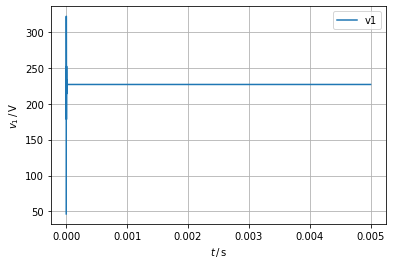

In [23]:
plt.plot(t, result[:steps, 1], label='v1')
# plt.plot(t,result[:steps,0], label = 'i1')
plt.xlabel(r'$t\,/\,\mathrm{s}$')
plt.ylabel('$v_{\mathrm{1}}\,/\,\mathrm{V}$')
# plt.title('{}'.format())
plt.legend()
plt.grid()
# plt.xlim([0, 0.00005])
# plt.ylim([49.25,50.1])
plt.show()

### ODEINT

In [18]:
i10 = 0
v10 = 0
iT10 = 0
i20 = 0
v20 = 0
iT20 = 0
t0 = 0

# x0 = np.array([i10, v10, iT10, i20, v20, iT20])
x0 = [i10, v10, iT10, i20, v20, iT20]

f_list = []
u_list = []

result = odeint(env_model_ode, x0, t, tfirst=True)
# ys = np.array(ys).flatten()

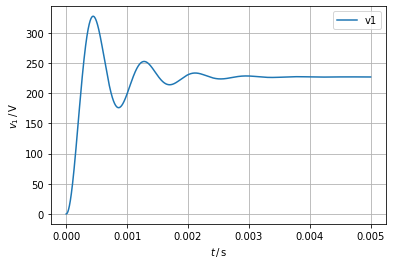

In [19]:
plt.plot(t, result[:steps, 1], label='v1')
# plt.plot(t,result[:steps,0], label = 'i1')
plt.xlabel(r'$t\,/\,\mathrm{s}$')
plt.ylabel('$v_{\mathrm{1}}\,/\,\mathrm{V}$')
# plt.title('{}'.format())
plt.legend()
plt.grid()
# plt.xlim([0, 0.005])
# plt.ylim([49.25,50.1])
plt.show()

## Python control

In [20]:
import scipy
import control
import copy